# Customer Churn Prediction for a Telecommunications Company          
          

## Abstract        
#### Objective        
This project explores various aspects of customer churn within a dataset, aiming to uncover significant variables predicting churn, thresholds for churn-inducing call failure rates, and the relationship between call failures and customer complaints. Additionally, it investigates whether these thresholds differ for high and low-value customers and estimates the potential reduction in churn resulting from a proposed business solution to decrease call failures by 50%.     
#### Methods      
The analysis encompasses a range of statistical and machine learning techniques. It begins with exploratory data analysis (EDA), including data transformations, outlier detection, and an assessment of the balance of response variables. Fitting distributions on predictors and evaluating feature importance through LASSO, Variance Inflation Factor (VIF), and significance tests inform subsequent modeling decisions. The project employs supervised (including model fits on all available features, engineered features, and Principal Component Analysis (PCA)) and unsupervised (K-Means and Mixture Model) modeling approaches. Model results are thoroughly examined, and simulations of new data are conducted to predict churn based on the selected model. The study addresses scientific questions through statistical inference, calculating confidence intervals for churn-related variables and estimating churn reduction.      
       
#### Results
Key findings include identifying significant predictors of churn, such as call failure rate thresholds, and discerning the impact of call failures on customer complaints. The analysis suggests that high and low-value customers exhibit similar churn patterns and estimates a 6% reduction in churn from a 50% decrease in call failures. Alternatively, a 50% reduction in inactivity of customers resulted in a more significant reduction in churn of approx. 23%. Furthermore, due to a difference in confidence intervals of call failure for churned and non-churned customers, it was identified that a customer is likely to churn if they experience greater than 9 call failures. Through comprehensive statistical modeling and simulation, the project provides insights into customer churn dynamics and proposes actionable strategies for mitigating churn by improving service quality.   

This integrated approach, combining statistical analysis with machine learning techniques, offers valuable insights into customer behavior and facilitates informed decision-making for customer retention strategies.

Dataset: https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset+dataset


# Table of Contents
1. [EDA](#eda)
   1. [Data Transformations](#transform)
   2. [Outliers](#outlier)
   3. [Balance of Response](#balance)
2. [Fitting Distributions on Predictors](#distributions)
3. [Feature Evalution of Importance](#feature_selection)
    1. [LASSO](#lasso)
    2. [VIF](#vif)
    3. [Significance Test](#z_test)
4. [Model Fitting](#model)
   1. [Supervised](#sup)
      1. [Model Fit on all Available Features](#initial)
      2. [Model Fit Using Engineered and Optimal VIF Features](#better)
      3. [PCA](#pca)
   2. [Unsupervised](#unsup)
      1. [K-Mean](#k-means)
      2. [Mixture Model](#mix)
   3. [Model Results](#model_results) 
      1. [Conclusion](#model_conclusion) 
5. [Simulating New Data](#sim)
   1. [Kernel Density Estimates on Individual Features](#kde)
   2. [Predicting Churn on new Sample](#prediction)
6. [Answering Scientific Questions](#sci_questions)
   1. [95% CI for Number of Call Failures for Churned Customers](#churn_call_fail)
      1. [Results](#q1_results)
   2. [95% CI for Number of Call Failures for Customers who Complained](#complain_call_fail)
      1. [Results](#q2_results)
   3. [% Reduction in Churn for a 50% Reduction in Number of Call Failures](#churn_reduced)
      1. [Results](#q3_results)

In [752]:
import pandas as pd
import altair as alt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, binom, poisson, gaussian_kde, gamma, weibull_min, lognorm
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.gam.api as smg
from sklearn.decomposition import PCA
from scipy.stats import expon
from scipy import stats
import math
from IPython.display import display, HTML
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats
np.random.seed(123)

<a id="eda"></a>
# EDA

### Data Processing and Analysis

<a id="transform"></a>
##### Data Transformations

In [753]:
data = pd.read_csv('Customer Churn.csv')

# changing status column from 1: Active, 2: In-Active to 0 and 1
data['Status'] = data['Status'] - 1

# changing Tariff Plan from 1: Pay as You Go, 2: Contractual to 0 and 1
data['Tariff Plan'] = data['Tariff Plan'] - 1

# changing Status column name to Inactivity to represent 0: False (active) and 1: True (inactive)
# changing Tariff Plan column name to Pay On Contract to represent 0: False (pay-as-you-go), 1: True (Contractual)
# Renaming other columns to make them consistent - removing 2 space between words, upper casing subsequent words
data.rename(columns={'Tariff Plan':'Pay On Contract','Status': 'Inactivity', 'Call  Failure':'Call Failure', 
                     'Subscription  Length':'Subscription Length', 
                     'Charge  Amount':'Charge Amount', 'Frequency of use':'Frequency of Use'}, inplace=True)

# Caluclating the call failure rate and adding it as a column 
data['Call Failure Rate'] = data['Call Failure'] / data['Frequency of Use']
data

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Churn,Call Failure Rate
0,8,0,38,0,4370,71,5,17,3,0,0,30,197.640,0,0.112676
1,0,0,39,0,318,5,7,4,2,0,1,25,46.035,0,0.000000
2,10,0,37,0,2453,60,359,24,3,0,0,30,1536.520,0,0.166667
3,10,0,38,0,4198,66,1,35,1,0,0,15,240.020,0,0.151515
4,3,0,38,0,2393,58,2,33,1,0,0,15,145.805,0,0.051724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,1,0,25,721.980,0,0.142857
3146,17,0,17,1,9237,177,80,42,5,0,0,55,261.210,0,0.096045
3147,13,0,18,4,3157,51,38,21,3,0,0,30,280.320,0,0.254902
3148,7,0,11,2,4695,46,222,12,3,0,0,30,1077.640,0,0.152174


##### Null Values

In [754]:
data.describe()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Churn,Call Failure Rate
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,2996.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,0.077778,0.248254,30.998413,470.972916,0.157143,0.144741
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993,0.170858
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,0.000000,0.000000,25.000000,113.801250,0.000000,0.034160
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,0.000000,0.000000,30.000000,228.480000,0.000000,0.102753
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,0.000000,0.000000,30.000000,788.388750,0.000000,0.195122
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,1.000000,1.000000,55.000000,2165.280000,1.000000,3.500000


In [755]:
print(data.info())

data['Call Failure Rate'].isnull().sum()
data[data.isnull().any(axis=1)]
data[(data['Call Failure'] == 0) & (data['Frequency of Use']==0)] # look at rows for Call Failure is NaN
data[data['Call Failure Rate']==0] # Compare it to rows where Call Failure rate is actually 0
# Don't want to remove the rows where Call Failure is NaN because there could be some analysis done on this set it to the mean of the column

mean_cfr = data['Call Failure Rate'].mean()
data['Call Failure Rate'] = data['Call Failure Rate'].fillna(value=mean_cfr)
data.loc[data['Call Failure']>data['Frequency of Use'],'Call Failure'] = data['Frequency of Use'] # can't have more failures then number of calls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of Use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Pay On Contract          3150 non-null   int64  
 10  Inactivity               3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
 14  Call Failure Rate       

#### Re-ordering columns to have response at the end

In [756]:
data = data[['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Churn']]

<a id="outlier"></a>
### Outliers

In [757]:
graph = []
for i in data.columns:
    chart = alt.Chart(data).mark_boxplot().encode(
        x=alt.X(f'{i}'), 
    )
    graph.append(chart)

alt.vconcat(*graph)

alt.VConcatChart(...)

<a id="balance"></a>
### Balance of Churn

In [758]:
chart = alt.Chart(data).mark_bar().encode(
    x=alt.X('Churn'),
    y=alt.Y('count()'))

chart

alt.Chart(...)

<a id="distributions"></a>
# Fitting distributions to Predictor/Features

In [759]:
data.columns

Index(['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Churn'],
      dtype='object')

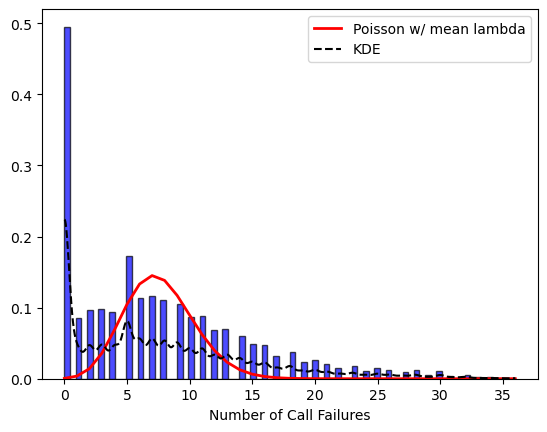

In [760]:
plt.hist(data['Call Failure'], bins=80, density=True, alpha=0.7, color='blue', edgecolor='black')

kde_call_failure = KernelDensity(bandwidth=0.4)
kde_call_failure.fit(data['Call Failure'].values.reshape(-1,1))
x = np.linspace(data['Call Failure'].min(), data['Call Failure'].max(), 1000).reshape(-1,1)


lambda_estimate = data['Call Failure'].mean()
max_call_failures = data['Call Failure'].max()
x_p = np.arange(0, max_call_failures+1)
poisson_dist = poisson.pmf(x_p, lambda_estimate)

plt.plot(x_p, poisson_dist, 'r', linewidth=2, label='Poisson w/ mean lambda')
plt.plot(x, np.exp(kde_call_failure.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Number of Call Failures')
plt.legend()
plt.show()

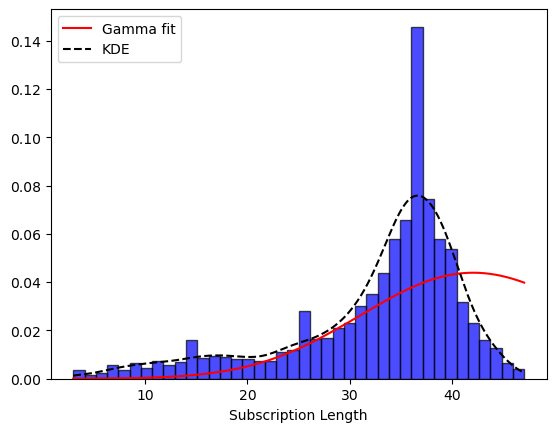

In [761]:
plt.hist(data['Subscription Length'], bins=40, density=True, alpha=0.7, color='blue', edgecolor='black')

a, loc, scale = gamma.fit(data['Subscription Length'])

x_f = np.linspace(data['Subscription Length'].min(), data['Subscription Length'].max(), 1000)
fitted_pdf = gamma.pdf(x, a, loc, scale)

kde_sub_length = KernelDensity(bandwidth=1.5)
kde_sub_length.fit(data['Subscription Length'].values.reshape(-1,1))
x = np.linspace(data['Subscription Length'].min(), data['Subscription Length'].max(), 1000).reshape(-1,1)

plt.plot(x_f, fitted_pdf, 'r', label='Gamma fit')
plt.plot(x, np.exp(kde_sub_length.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Subscription Length')
plt.legend()
plt.show()

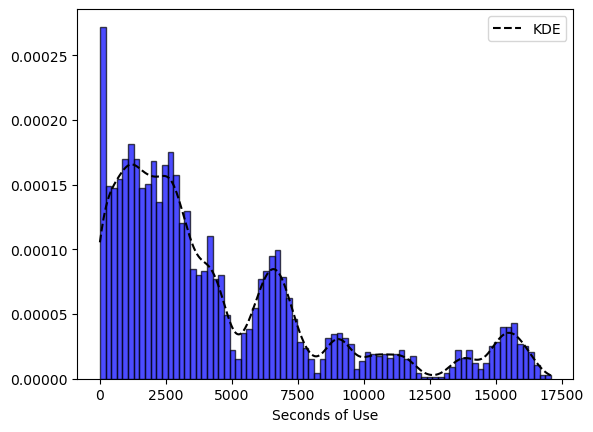

In [762]:
# Time of Use
plt.hist(data['Seconds of Use'], bins=80, density=True, alpha=0.7, color='blue', edgecolor='black')

kde_sec_of_use = KernelDensity(bandwidth=350)
kde_sec_of_use.fit(data['Seconds of Use'].values.reshape(-1,1))
x = np.linspace(data['Seconds of Use'].min(), data['Seconds of Use'].max(), 1000).reshape(-1,1)


plt.plot(x, np.exp(kde_sec_of_use.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Seconds of Use')
plt.legend()
plt.show()

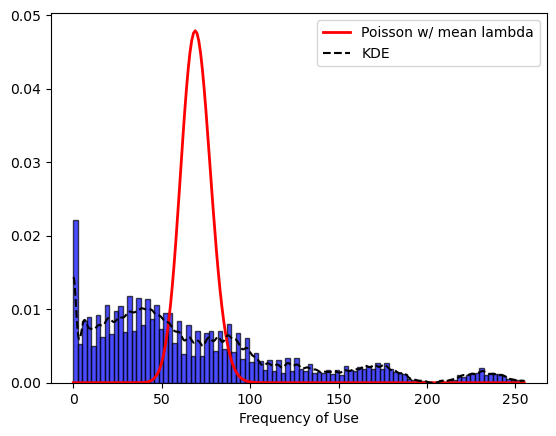

In [763]:
# Number of Calls - Poisson
plt.hist(data['Frequency of Use'], bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')

kde_freq_of_use = KernelDensity(bandwidth=1.5)
kde_freq_of_use.fit(data['Frequency of Use'].values.reshape(-1,1))
x = np.linspace(data['Frequency of Use'].min(), data['Frequency of Use'].max(), 1000).reshape(-1,1)

lambda_estimate = data['Frequency of Use'].mean()
max = data['Frequency of Use'].max()
x_p = np.arange(0, max+1)
poisson_dist = poisson.pmf(x_p, lambda_estimate)

plt.plot(x_p, poisson_dist, 'r', linewidth=2, label='Poisson w/ mean lambda')
plt.plot(x, np.exp(kde_freq_of_use.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Frequency of Use')
plt.legend()
plt.show()

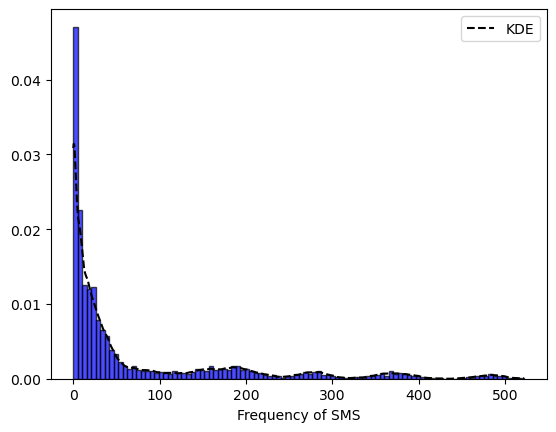

In [764]:
# Number of SMS - Poisson
plt.hist(data['Frequency of SMS'], bins=100, alpha=0.7, density=True, color='blue', edgecolor='black')

kde_freq_of_sms = KernelDensity(bandwidth=3)
kde_freq_of_sms.fit(data['Frequency of SMS'].values.reshape(-1,1))
x = np.linspace(data['Frequency of SMS'].min(), data['Frequency of SMS'].max(), 1000).reshape(-1,1)


plt.plot(x, np.exp(kde_freq_of_sms.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Frequency of SMS')
plt.legend()
plt.show()

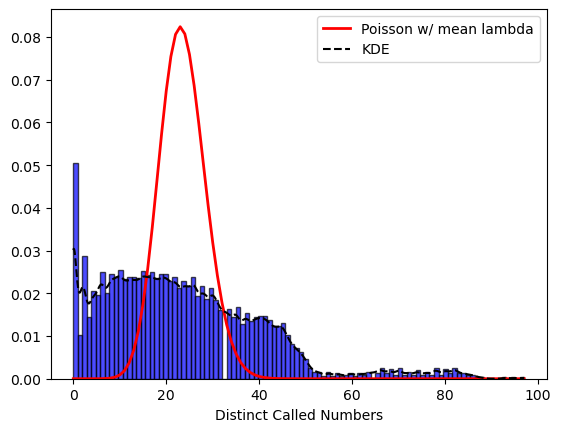

In [765]:
plt.hist(data['Distinct Called Numbers'], bins=100, alpha=0.7, density=True, color='blue', edgecolor='black')

kde_distinct_num_called = KernelDensity(bandwidth=0.7)
kde_distinct_num_called.fit(data['Distinct Called Numbers'].values.reshape(-1,1))
x = np.linspace(data['Distinct Called Numbers'].min(), data['Distinct Called Numbers'].max(), 1000).reshape(-1,1)

lambda_estimate = data['Distinct Called Numbers'].mean()
max = data['Distinct Called Numbers'].max()
x_p = np.arange(0, max+1)
poisson_dist = poisson.pmf(x_p, lambda_estimate)

plt.plot(x_p, poisson_dist, 'r', linewidth=2, label='Poisson w/ mean lambda')

plt.plot(x, np.exp(kde_distinct_num_called.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Distinct Called Numbers')
plt.legend()
plt.show()

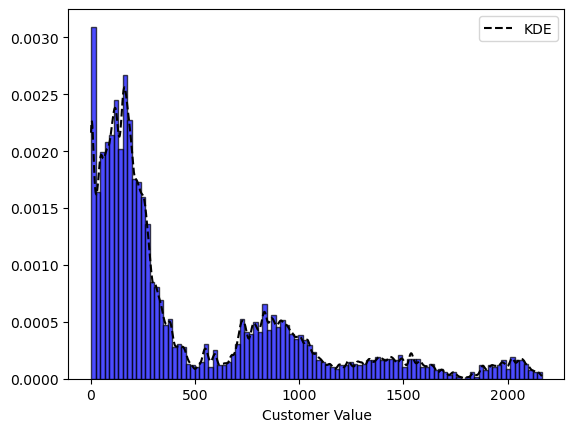

In [766]:
plt.hist(data['Customer Value'], bins=100, alpha=0.7, density=True, color='blue', edgecolor='black')

kde_cust_value = KernelDensity(bandwidth=10)
kde_cust_value.fit(data['Customer Value'].values.reshape(-1,1))
x = np.linspace(data['Customer Value'].min(), data['Customer Value'].max(), 1000).reshape(-1,1)

plt.plot(x, np.exp(kde_cust_value.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Customer Value')
plt.legend()
plt.show()

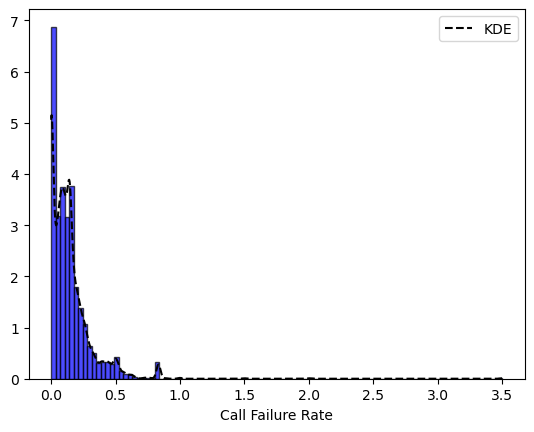

In [767]:
plt.hist(data['Call Failure Rate'], bins=100, density=True, alpha=0.7, 
         color='blue', edgecolor='black')

kde_call_fail_rate = KernelDensity(bandwidth=0.016)
kde_call_fail_rate.fit(data['Call Failure Rate'].values.reshape(-1,1))
x = np.linspace(data['Call Failure Rate'].min(), data['Call Failure Rate'].max(), 1000).reshape(-1,1)

plt.plot(x, np.exp(kde_call_fail_rate.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.legend()
plt.xlabel('Call Failure Rate')
plt.show()

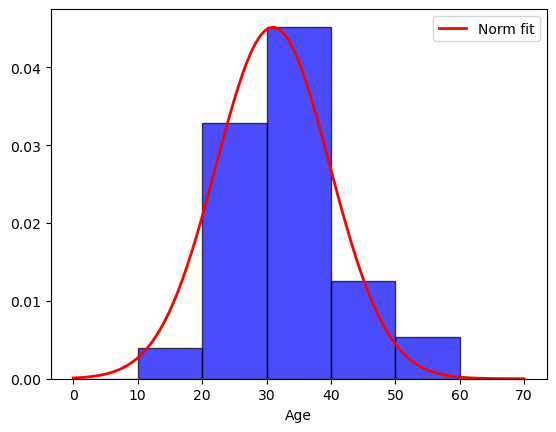

In [768]:
norm_fit = norm.fit(data['Age'])
x = np.linspace(0, 70, 100)
norm_pdf = norm.pdf(x, *norm_fit)

plt.hist(data['Age'], bins=[0,10,20,30,40,50,60,70], density=True, alpha=0.7, color='blue', edgecolor='black')
# Adding labels and title
plt.xlabel('Age')
plt.plot(x, norm_pdf, 'r', linewidth=2, label='Norm fit')

# Display the plot
plt.legend()
plt.show()

In [769]:
print(data[data['Age Group']==1]['Age'].value_counts())

print(data[data['Age Group']==2]['Age'].value_counts())

print(data[data['Age Group']==3]['Age'].value_counts())

print(data[data['Age Group']==4]['Age'].value_counts())

print(data[data['Age Group']==5]['Age'].value_counts())

Age
15    123
Name: count, dtype: int64
Age
25    1037
Name: count, dtype: int64
Age
30    1425
Name: count, dtype: int64
Age
45    395
Name: count, dtype: int64
Age
55    170
Name: count, dtype: int64


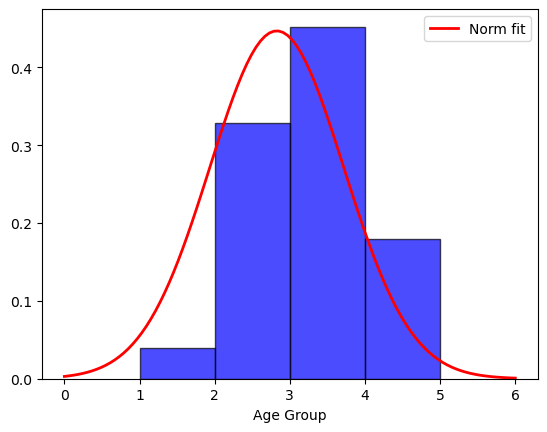

In [770]:
plt.hist(data['Age Group'], bins=[1, 2, 3, 4, 5], density=True, alpha=0.7, color='blue', edgecolor='black')

norm_age_group = norm.fit(data['Age Group'])
x = np.linspace(0, 6, 100)
norm_pdf = norm.pdf(x, *norm_age_group)

plt.plot(x, norm_pdf, 'r', linewidth=2, label='Norm fit')

plt.xlabel('Age Group')
# Display the plot
plt.legend()
plt.show()

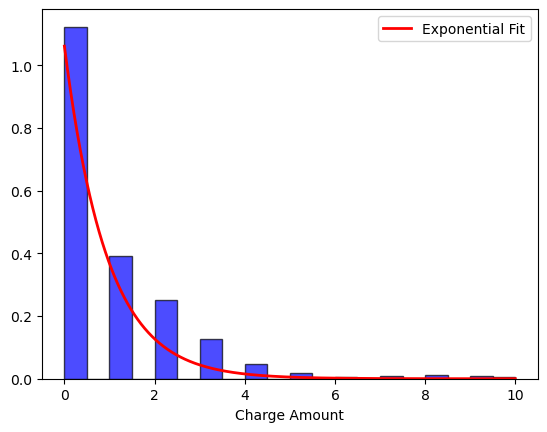

In [771]:
plt.hist(data['Charge Amount'], bins=20, alpha=0.7, density=True, color='blue', edgecolor='black')

loc_charge_amount, scale_charge_amount = expon.fit(data['Charge Amount'])
x = np.linspace(0, np.max(data['Charge Amount']), 1000)
y = expon.pdf(x, loc=loc_charge_amount, scale=scale_charge_amount)
plt.plot(x, y, 'r-', linewidth=2, label='Exponential Fit')

plt.legend()
plt.xlabel('Charge Amount')
plt.show()

In [772]:
p_no_complain = data['Complains'].value_counts().values[1]/data.shape[0]
print(p_no_complain)

p_no_pay_on_contract = data['Pay On Contract'].value_counts().values[1]/data.shape[0]
print(p_no_pay_on_contract)

p_inactive = data['Inactivity'].value_counts().values[1]/data.shape[0]
print(p_inactive)

0.07650793650793651
0.07777777777777778
0.24825396825396825


In [773]:
data.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Call Failure Rate,Churn
0,8,0,38,0,4370,71,5,17,3,0,0,30,197.640,0.112676,0
1,0,0,39,0,318,5,7,4,2,0,1,25,46.035,0.000000,0
2,10,0,37,0,2453,60,359,24,3,0,0,30,1536.520,0.166667,0
3,10,0,38,0,4198,66,1,35,1,0,0,15,240.020,0.151515,0
4,3,0,38,0,2393,58,2,33,1,0,0,15,145.805,0.051724,0


<a id="feature_selection"></a>
# Feature Selection

In [774]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Churn'), data['Churn'], test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

<a id="lasso"></a>
### Lasso

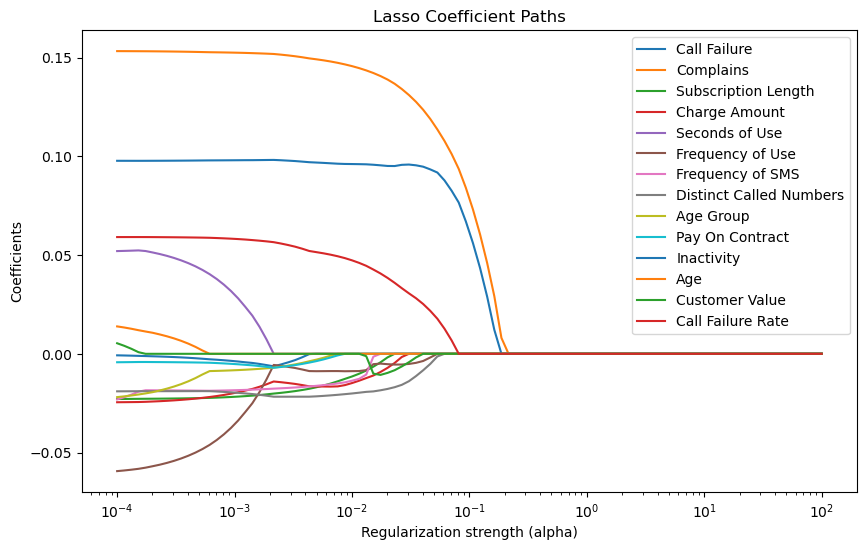

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of Use,Frequency of SMS,Distinct Called Numbers,Age Group,Pay On Contract,Inactivity,Age,Customer Value,Call Failure Rate
0,-0.0,0.143488,-0.008482,-0.012295,-0.0,-0.008268,-0.010526,-0.019271,-0.0,-0.0,0.095938,-0.0,-0.001187,0.044549
1,-0.0,0.142172,-0.006522,-0.010987,-0.0,-0.005244,-0.001463,-0.019035,-0.0,-0.0,0.095723,-0.0,-0.010018,0.042670
2,-0.0,0.140632,-0.004321,-0.009214,-0.0,-0.004962,-0.000000,-0.018476,-0.0,-0.0,0.095432,-0.0,-0.010685,0.040686
3,-0.0,0.138857,-0.001798,-0.007111,-0.0,-0.005254,-0.000000,-0.017783,-0.0,-0.0,0.095102,-0.0,-0.009662,0.038428
4,-0.0,0.136714,-0.000000,-0.004618,-0.0,-0.005448,-0.000000,-0.016901,-0.0,-0.0,0.095068,-0.0,-0.008303,0.035924
5,-0.0,0.134057,-0.000000,-0.001615,-0.0,-0.005421,-0.000000,-0.015714,-0.0,-0.0,0.095675,-0.0,-0.006396,0.033219
6,-0.0,0.131027,-0.000000,-0.000000,-0.0,-0.005139,-0.000000,-0.013874,-0.0,-0.0,0.095822,-0.0,-0.004256,0.030614
7,-0.0,0.127569,-0.000000,-0.000000,-0.0,-0.004572,-0.000000,-0.011273,-0.0,-0.0,0.095433,-0.0,-0.001845,0.028130
8,-0.0,0.123571,-0.000000,-0.000000,-0.0,-0.003635,-0.000000,-0.008342,-0.0,-0.0,0.094738,-0.0,-0.000000,0.025219
9,-0.0,0.118926,-0.000000,-0.000000,-0.0,-0.001870,-0.000000,-0.005131,-0.0,-0.0,0.093370,-0.0,-0.000000,0.021750


In [775]:
alphas = np.logspace(-4, 2, 100)
coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)

plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficient Paths')
plt.legend(labels=x_train.drop(columns=[]).columns) 
plt.show()
a = pd.DataFrame(coefs[35:50], columns=x_train.drop(columns=[]).columns)
a

<a id="vif"></a>
### Variance Inflation Factor

In [776]:
endog = y_train
exog = x_train
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score # age and age group probably has correlation so pick age group to ignore potential decision boundries in-between ages

{'const': 44.836680389710246,
 'Call Failure': 4.413010077252894,
 'Complains': 1.1744787409469246,
 'Subscription Length': 1.1830888669584172,
 'Charge Amount': 3.2178126628108688,
 'Seconds of Use': 22.58739381525173,
 'Frequency of Use': 19.640052786578465,
 'Frequency of SMS': 45.22219277034055,
 'Distinct Called Numbers': 2.5313322187863565,
 'Age Group': 14.124654564551301,
 'Pay On Contract': 1.5795993632416019,
 'Inactivity': 1.8773290866879004,
 'Age': 14.826654871735695,
 'Customer Value': 57.74411765768797,
 'Call Failure Rate': 2.0629272043971696}

In [777]:
endog = y_train
exog = x_train.drop(columns=['Age'])
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score # frequency of use correlated with seconds of use && frequency of sms correlated with customer value perhaps

{'const': 38.00744342633,
 'Call Failure': 4.372422390225966,
 'Complains': 1.168987416712682,
 'Subscription Length': 1.181497203384901,
 'Charge Amount': 3.2170734423706606,
 'Seconds of Use': 22.1168318102296,
 'Frequency of Use': 19.608509135295563,
 'Frequency of SMS': 43.3968711189607,
 'Distinct Called Numbers': 2.4473566965072084,
 'Age Group': 2.102542418377987,
 'Pay On Contract': 1.5452738666271029,
 'Inactivity': 1.8765478613724593,
 'Customer Value': 54.66782388996104,
 'Call Failure Rate': 2.0528385087280148}

Frequency of use correlated with Seconds of use -> then make a new feature which is average seconds per call   
1. Seconds of Use (numerical): total seconds of calls over 9 month period2. Frequency of use (numerical): total number of calls over 9 month period

In [778]:
data['Average Sec per Call'] = data['Seconds of Use']/data['Frequency of Use']
mean_avg_sec_per_call = data['Average Sec per Call'].mean()
data.fillna({'Average Sec per Call':mean_avg_sec_per_call}, inplace=True)

data = data[['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Average Sec per Call',
       'Churn']] # re-ordering to have response column at the end

kde_average_sec_per_call = KernelDensity(bandwidth=12)
kde_average_sec_per_call.fit(data['Average Sec per Call'].values.reshape(-1,1))

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn', 'Age', 'Seconds of Use']), data['Churn'], 
                                                    test_size=0.2, random_state=42)

endog = y_train
exog = x_train
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

/tmp/ipykernel_238306/3245886290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Average Sec per Call'] = data['Seconds of Use']/data['Frequency of Use']
/tmp/ipykernel_238306/3245886290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna({'Average Sec per Call':mean_avg_sec_per_call}, inplace=True)


{'const': 39.20408679323885,
 'Call Failure': 4.072376191647108,
 'Complains': 1.1681343997811493,
 'Subscription Length': 1.2007175163227488,
 'Charge Amount': 2.5111047898900094,
 'Frequency of Use': 8.43636506131548,
 'Frequency of SMS': 31.430387933397995,
 'Distinct Called Numbers': 2.438062188804947,
 'Age Group': 1.9456675941647166,
 'Pay On Contract': 1.3613043514587309,
 'Inactivity': 1.861914569176541,
 'Customer Value': 39.40304957873087,
 'Call Failure Rate': 2.0867593508409303,
 'Average Sec per Call': 1.328504579248906}

Between Customer value and Frequency of SMS, remove frequency of sms because based on Lasso it goes to 0 before Customer Value

In [779]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Churn', 'Age', 'Seconds of Use', 'Frequency of SMS']), 
                                                    data['Churn'], test_size=0.2, random_state=42)

endog = y_train
exog = x_train
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 37.878955065474166,
 'Call Failure': 3.8799041873195628,
 'Complains': 1.1634499860765335,
 'Subscription Length': 1.1935637966059744,
 'Charge Amount': 2.4756125328811613,
 'Frequency of Use': 3.6161356956007777,
 'Distinct Called Numbers': 2.4345454252933223,
 'Age Group': 1.2615035105810766,
 'Pay On Contract': 1.3602007816093478,
 'Inactivity': 1.8570667879548919,
 'Customer Value': 1.4810279752825513,
 'Call Failure Rate': 2.0628915783890345,
 'Average Sec per Call': 1.2110893650675132}

From the above, all VIF values below 10, except for the const. Therefore, multicollinearity significantly reduced. 

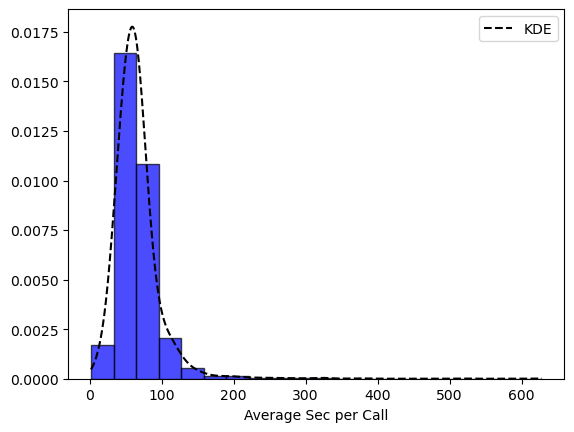

In [780]:
plt.hist(data['Average Sec per Call'], bins=20, alpha=0.7, density=True, color='blue', edgecolor='black')

x = np.linspace(data['Average Sec per Call'].min(), data['Average Sec per Call'].max(), 1000).reshape(-1,1)

plt.plot(x, np.exp(kde_average_sec_per_call.score_samples(x)), label='KDE', color='black', linestyle='--')
plt.xlabel('Average Sec per Call')
plt.legend()
plt.show()

<a id="z_test"></a>
### Comparing marginal distributions of each feature between churn and not churned

In [781]:
N = len(data.columns)-1
z_score = {}
for i in range(N):
    mu_0, sigma_0 = norm.fit(data[data['Churn'] == 0].iloc[:,[i,15]])
    mu_1, sigma_1 = norm.fit(data[data['Churn'] == 1].iloc[:,[i,15]])
    z = (mu_0-mu_1) / np.sqrt(sigma_0**2 + sigma_1**2)
    z_score[data.columns[i]] = z
z_score

{'Call Failure': -0.044713908423587405,
 'Complains': -1.4909644129411967,
 'Subscription Length': -0.004803669460067019,
 'Charge Amount': -0.05596636778159771,
 'Seconds of Use': 0.4134023111059113,
 'Frequency of Use': 0.3832342546417229,
 'Frequency of SMS': 0.3506855753343583,
 'Distinct Called Numbers': 0.30245884315673255,
 'Age Group': -0.2581308989667535,
 'Pay On Contract': -0.8518335480541744,
 'Inactivity': -1.8667652346109505,
 'Age': -0.01243243611162162,
 'Customer Value': 0.4293941629761614,
 'Call Failure Rate': -1.3498067472208841,
 'Average Sec per Call': -0.003159812627362492}

Columns which are likely to fail significane test at predicting churn based on z-score:
1. Customer Value
2. Seconds of Use
3. Frequency of SMS
5. Frequency of Use
6. Distinct Called Numbers

**Note:** Assumes normal distribution, which may be true for large enough sample size, however, this data set has less than 4000 rows, of which only about 500 are for customers who have churned (desired class to predict in response - very unbalanced). As such, these scores may be off. 

<a id="model"></a>
# Model Fitting

<a id="sup"></a>
## Supervised Methods

<a id="initial"></a>
### Fitting models with **all features** - engineered + original
**Note:** These models will be referred to as the **"Original Models"**     
Settings:
1. using all available features (engineered plus original) except 'Age', choosing to use 'Age Group'
2. accounting for imbalanced classes in response
3. cross-validation scored on 'roc_auc' for binary response

In [782]:
x_train_ori, x_test_ori, y_train_ori, y_test_ori = train_test_split(data.drop(columns=['Churn', 'Age']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

print(y_train_ori.value_counts())
print(y_test_ori.value_counts())

scaler_ori = StandardScaler()
x_train_ori_scaled = scaler_ori.fit_transform(x_train_ori)
x_test_ori_scaled = scaler_ori.transform(x_test_ori)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


#### Cross-Validation

In [783]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
svc = SVC(probability=True, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
btc = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
models = {'log_ori': logreg, 'svc_ori': svc, 'rf_ori': rf, 'btc_ori': btc}

scoring=['f1', 'roc_auc', 'balanced_accuracy', 'matthews_corrcoef']
cv_scores_mean_ori = {}
cv_scores_stdv_ori = {}
for name, model in models.items():
    # Compute cross-validation scores
    scores = cross_validate(model, x_train_ori_scaled, y_train_ori, cv=10, scoring=scoring)
    cv_scores_mean_ori[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}
    cv_scores_stdv_ori[name] = {metric: scores[f'test_{metric}'].std() for metric in scoring}

cv_scores_df_mean_ori = pd.DataFrame(cv_scores_mean_ori).T
print(cv_scores_df_mean_ori)
cv_scores_df_stdv_ori = pd.DataFrame(cv_scores_stdv_ori).T
print(cv_scores_df_stdv_ori)

               f1   roc_auc  balanced_accuracy  matthews_corrcoef
log_ori  0.644243  0.939619           0.865402           0.595264
svc_ori  0.721619  0.963942           0.897920           0.681469
rf_ori   0.848882  0.983838           0.896582           0.826731
btc_ori  0.881626  0.987530           0.933449           0.861203
               f1   roc_auc  balanced_accuracy  matthews_corrcoef
log_ori  0.030367  0.013700           0.024879           0.038954
svc_ori  0.033403  0.008119           0.021860           0.040182
rf_ori   0.027893  0.006985           0.025774           0.029493
btc_ori  0.023698  0.004593           0.017154           0.027989


#### Test Set

In [784]:
logreg_ori = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_ori.fit(x_train_ori_scaled, y_train_ori)

svc_ori = SVC(probability=True, class_weight='balanced', random_state=42)
svc_ori.fit(x_train_ori_scaled, y_train_ori)

rf_ori = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_ori.fit(x_train_ori_scaled, y_train_ori)

btc_ori = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
btc_ori.fit(x_train_ori_scaled, y_train_ori)

models_ori = {'log_ori': logreg_ori, 'svc_ori': svc_ori, 'rf_ori': rf_ori, 'btc_ori': btc_ori}
model_scores_ori = {}
for model in models_ori:
    y_pred_ori = models_ori[model].predict(x_test_ori_scaled)
    y_pred_prob_ori = models_ori[model].predict_proba(x_test_ori_scaled)[:, 1]
    f1 = f1_score(y_test_ori, y_pred_ori)
    ll = log_loss(y_test_ori, y_pred_prob_ori)
    roc_auc = roc_auc_score(y_test_ori, y_pred_prob_ori)
    cm = confusion_matrix(y_test_ori, y_pred_ori)
    model_scores_ori[model] = [f1, ll, roc_auc, cm]
model_scores_ori

{'log_ori': [0.6522911051212937,
  0.35667477092715527,
  0.9220035778175314,
  array([[538, 107],
         [ 22, 121]])],
 'svc_ori': [0.749279538904899,
  0.202458074828328,
  0.9549953922046945,
  array([[571,  74],
         [ 13, 130]])],
 'rf_ori': [0.8405797101449276,
  0.1449981732217077,
  0.9819591261451728,
  array([[628,  17],
         [ 27, 116]])],
 'btc_ori': [0.8551724137931034,
  0.1391251548731362,
  0.9845449124518892,
  array([[622,  23],
         [ 19, 124]])]}

<a id="better"></a>
### Fitting models with **sub-set of features** - engineered + VIF optimal
**Note:** These models will be referred to as the **"Subset Models"**     
Settings:
1. using engineered features plus features with minimal multi-collinearity from above VIF analysis
2. accounting for imbalanced classes in response
3. cross-validation scored on 'roc_auc' for binary response

In [785]:
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(data.drop(columns=['Churn', 'Age', 'Seconds of Use', 'Frequency of SMS']), 
                                                    data['Churn'], test_size=0.25, random_state=42)

print(y_train_sub.value_counts())
print(y_test_sub.value_counts())

scaler_sub = StandardScaler()
x_train_sub_scaled = scaler_sub.fit_transform(x_train_sub)
x_test_sub_scaled = scaler_sub.transform(x_test_sub)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


#### Cross-validation

In [786]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
svc = SVC(probability=True, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
btc = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
models = {'log_sub': logreg, 'svc_sub': svc, 'rf_sub': rf, 'btc_sub': btc}
scoring=['f1', 'roc_auc', 'balanced_accuracy', 'matthews_corrcoef']

cv_scores_mean_sub = {}
cv_scores_stdv_sub = {}
for name, model in models.items():
    # Compute cross-validation scores
    scores = cross_validate(model, x_train_sub_scaled, y_train_sub, cv=10, scoring=scoring)
    cv_scores_mean_sub[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}
    cv_scores_stdv_sub[name] = {metric: scores[f'test_{metric}'].std() for metric in scoring}

cv_scores_df_mean_sub = pd.DataFrame(cv_scores_mean_sub).T
print(cv_scores_df_mean_sub)
cv_scores_df_stdv_sub = pd.DataFrame(cv_scores_stdv_sub).T
print(cv_scores_df_stdv_sub)

               f1   roc_auc  balanced_accuracy  matthews_corrcoef
log_sub  0.638434  0.939003           0.860659           0.587713
svc_sub  0.734446  0.964529           0.900720           0.695005
rf_sub   0.844053  0.981724           0.893436           0.821342
btc_sub  0.882251  0.987593           0.935769           0.861952
               f1   roc_auc  balanced_accuracy  matthews_corrcoef
log_sub  0.031621  0.014006           0.028251           0.041969
svc_sub  0.035150  0.009369           0.022810           0.042248
rf_sub   0.025544  0.009063           0.025160           0.026245
btc_sub  0.029707  0.005116           0.020600           0.035202


#### Test Set

In [787]:
logreg_sub = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_sub.fit(x_train_sub_scaled, y_train_sub)

svc_sub = SVC(probability=True, class_weight='balanced', random_state=42)
svc_sub.fit(x_train_sub_scaled, y_train_sub)

rf_sub = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_sub.fit(x_train_sub_scaled, y_train_sub)

btc_sub = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
btc_sub.fit(x_train_sub_scaled, y_train_sub)

models_sub = {'log_sub': logreg_sub, 'svc_sub': svc_sub, 'rf_sub': rf_sub, 'btc_sub': btc_sub}
model_scores_sub = {}
for name, model in models_sub.items():
    y_pred_sub = model.predict(x_test_sub_scaled)
    y_pred_prob_sub = model.predict_proba(x_test_sub_scaled)[:, 1]
    f1 = f1_score(y_test_sub, y_pred_sub)
    ll = log_loss(y_test_sub, y_pred_prob_sub)
    roc_auc = roc_auc_score(y_test_sub, y_pred_prob_sub)
    cm = confusion_matrix(y_test_sub, y_pred_sub)
    model_scores_sub[name] = [f1, ll, roc_auc, cm]
model_scores_sub

{'log_sub': [0.6558265582655827,
  0.3598001139535396,
  0.9210386512712094,
  array([[540, 105],
         [ 22, 121]])],
 'svc_sub': [0.760233918128655,
  0.19821950751938686,
  0.956318100504147,
  array([[576,  69],
         [ 13, 130]])],
 'rf_sub': [0.8447653429602888,
  0.14081557019727373,
  0.9826638477801268,
  array([[628,  17],
         [ 26, 117]])],
 'btc_sub': [0.8749999999999999,
  0.12558130097154774,
  0.9870656475307638,
  array([[626,  19],
         [ 17, 126]])]}

<a id="pca"></a>
### PCA
**Note:** Taking same training/test set as the original models ie. x_train_ori, y_train_ori..etc from above

In [788]:
print(y_train_ori.value_counts())
print(y_test_ori.value_counts())

pca = PCA(random_state=42)
x_train_ori_pca = pca.fit_transform(x_train_ori_scaled)
x_test_ori_pca = pca.transform(x_test_ori_scaled)

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


In [789]:
exog = pd.DataFrame(x_test_ori_pca, columns=x_train_ori.columns)
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 1.0102717894086974,
 'Call Failure': 1.02064268731066,
 'Complains': 1.0559072698929224,
 'Subscription Length': 1.0658070078802182,
 'Charge Amount': 1.0140449469719175,
 'Seconds of Use': 1.0128563339072594,
 'Frequency of Use': 1.0486651311584543,
 'Frequency of SMS': 1.0597606822203012,
 'Distinct Called Numbers': 1.0707868323872947,
 'Age Group': 1.0278024494120153,
 'Pay On Contract': 1.0365640933874802,
 'Inactivity': 1.1067183414866855,
 'Customer Value': 1.1794284619563509,
 'Call Failure Rate': 1.0520129247338759,
 'Average Sec per Call': 1.0235346124125106}

#### Cross-validation

In [790]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
svc = SVC(probability=True, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
btc = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
models = {'log_pca_ori': logreg, 'svc_pca_ori': svc, 'rf_pca_ori': rf, 'btc_pca_ori': btc}

scoring=['f1', 'roc_auc', 'balanced_accuracy', 'matthews_corrcoef']
cv_scores_mean_pca_ori = {}
cv_scores_stdv_pca_ori = {}
for name, model in models.items():
    # Compute cross-validation scores
    scores = cross_validate(model, x_train_ori_pca, y_train_ori, cv=10, scoring=scoring)
    cv_scores_mean_pca_ori[name] = {metric: scores[f'test_{metric}'].mean() for metric in scoring}
    cv_scores_stdv_pca_ori[name] = {metric: scores[f'test_{metric}'].std() for metric in scoring}

cv_scores_df_mean_pca_ori = pd.DataFrame(cv_scores_mean_pca_ori).T
print(cv_scores_df_mean_pca_ori)
cv_scores_df_stdv_pca_ori = pd.DataFrame(cv_scores_stdv_pca_ori).T
print(cv_scores_df_stdv_pca_ori)

                   f1   roc_auc  balanced_accuracy  matthews_corrcoef
log_pca_ori  0.644243  0.939612           0.865402           0.595264
svc_pca_ori  0.721619  0.963949           0.897920           0.681469
rf_pca_ori   0.806723  0.980695           0.865666           0.780612
btc_pca_ori  0.847641  0.983297           0.910229           0.821558
                   f1   roc_auc  balanced_accuracy  matthews_corrcoef
log_pca_ori  0.030367  0.013702           0.024879           0.038954
svc_pca_ori  0.033403  0.008127           0.021860           0.040182
rf_pca_ori   0.028155  0.007407           0.025074           0.031004
btc_pca_ori  0.019787  0.008097           0.017804           0.023053


#### Test Set

In [791]:
logreg_pca = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_pca.fit(x_train_ori_pca, y_train_ori)

svc_pca = SVC(probability=True, class_weight='balanced', random_state=42)
svc_pca.fit(x_train_ori_pca, y_train_ori)

rf_pca = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_pca.fit(x_train_ori_pca, y_train_ori)

btc_pca = lgb.LGBMClassifier(verbosity=-1, class_weight='balanced', random_state=42)
btc_pca.fit(x_train_ori_pca, y_train_ori)

models_pca = {'log_pca': logreg_pca, 'svc_pca': svc_pca, 'rf_pca': rf_pca, 'btc_pca': btc_pca}
model_scores_pca = {}
for name, model in models_pca.items():
    y_pred_pca = model.predict(x_test_ori_pca)
    y_pred_prob_pca = model.predict_proba(x_test_ori_pca)[:, 1]
    f1 = f1_score(y_test_ori, y_pred_pca)
    ll = log_loss(y_test_ori, y_pred_prob_pca)
    roc_auc = roc_auc_score(y_test_ori, y_pred_prob_pca)
    cm = confusion_matrix(y_test_ori, y_pred_pca)
    model_scores_pca[name] = [f1, ll, roc_auc, cm]
model_scores_pca

{'log_pca': [0.6522911051212937,
  0.3566747709271548,
  0.9220035778175314,
  array([[538, 107],
         [ 22, 121]])],
 'svc_pca': [0.749279538904899,
  0.20245807482832903,
  0.9549953922046945,
  array([[571,  74],
         [ 13, 130]])],
 'rf_pca': [0.8278388278388279,
  0.15713327459493764,
  0.9762346180950832,
  array([[628,  17],
         [ 30, 113]])],
 'btc_pca': [0.8749999999999999,
  0.1425444263450649,
  0.982598796552285,
  array([[626,  19],
         [ 17, 126]])]}

<a id="unsup"></a>
## Unsupervised Methods

<a id="k-means"></a>
### K-Means

In [792]:
print(y_train_sub.value_counts())
print(y_test_sub.value_counts())

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


In [793]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=25)
kmeans.fit(x_train_sub_scaled)
y_pred_kmean = kmeans.predict(x_test_sub_scaled)

In [794]:
cm_kmean = confusion_matrix(y_test_sub, y_pred_kmean)
cm_kmean

array([[288, 357],
       [  6, 137]])

<a id="mix"></a>
### Mixture Model   
**Note:** Initially attemped with engineered and optimal VIF features, but better performance observed from using all columns including original and engineered.

In [795]:
print(y_train_ori.value_counts())
print(y_test_ori.value_counts())

Churn
0    2010
1     352
Name: count, dtype: int64
Churn
0    645
1    143
Name: count, dtype: int64


In [796]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(x_train_ori_scaled)

y_pred_gmm = gmm.predict(x_test_ori_scaled)
cm_gmm = confusion_matrix(y_test_ori, y_pred_gmm)
cm_gmm

array([[494, 151],
       [ 18, 125]])

<a id="model_results"></a>
## Results

In [797]:
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display(HTML(html_str.replace('table','table style="display:inline;margin-right:20px;"')))

print('Cross-Validation Results')
display_side_by_side(cv_scores_df_mean_ori, cv_scores_df_stdv_ori)
display_side_by_side(cv_scores_df_mean_sub, cv_scores_df_stdv_sub)
display_side_by_side(cv_scores_df_mean_pca_ori, cv_scores_df_stdv_pca_ori)

print('')
print('Test Set Results')

df_ori = pd.DataFrame(model_scores_ori).transpose()
df_ori.columns = ['Accuracy', 'Error Rate', 'AUC', 'Confusion Matrix']
df_sub = pd.DataFrame(model_scores_sub).transpose()
df_sub.columns = ['Accuracy', 'Error Rate', 'AUC', 'Confusion Matrix']
df_pca = pd.DataFrame(model_scores_pca).transpose()
df_pca.columns = ['Accuracy', 'Error Rate', 'AUC', 'Confusion Matrix']

# Convert confusion matrix arrays to string for better display
df_ori['Confusion Matrix'] = df_ori['Confusion Matrix'].apply(lambda x: str(x))
df_sub['Confusion Matrix'] = df_sub['Confusion Matrix'].apply(lambda x: str(x))
df_pca['Confusion Matrix'] = df_pca['Confusion Matrix'].apply(lambda x: str(x))

display_side_by_side(df_ori, df_sub, df_pca)

display(cm_kmean)
display(cm_gmm)

Cross-Validation Results


,f1,roc_auc,balanced_accuracy,matthews_corrcoef
log_ori,0.644243,0.939619,0.865402,0.595264
svc_ori,0.721619,0.963942,0.897920,0.681469
rf_ori,0.848882,0.983838,0.896582,0.826731
btc_ori,0.881626,0.987530,0.933449,0.861203
,f1,roc_auc,balanced_accuracy,matthews_corrcoef
log_ori,0.030367,0.013700,0.024879,0.038954
svc_ori,0.033403,0.008119,0.021860,0.040182
rf_ori,0.027893,0.006985,0.025774,0.029493
btc_ori,0.023698,0.004593,0.017154,0.027989


,f1,roc_auc,balanced_accuracy,matthews_corrcoef
log_sub,0.638434,0.939003,0.860659,0.587713
svc_sub,0.734446,0.964529,0.900720,0.695005
rf_sub,0.844053,0.981724,0.893436,0.821342
btc_sub,0.882251,0.987593,0.935769,0.861952
,f1,roc_auc,balanced_accuracy,matthews_corrcoef
log_sub,0.031621,0.014006,0.028251,0.041969
svc_sub,0.035150,0.009369,0.022810,0.042248
rf_sub,0.025544,0.009063,0.025160,0.026245
btc_sub,0.029707,0.005116,0.020600,0.035202


,f1,roc_auc,balanced_accuracy,matthews_corrcoef
log_pca_ori,0.644243,0.939612,0.865402,0.595264
svc_pca_ori,0.721619,0.963949,0.897920,0.681469
rf_pca_ori,0.806723,0.980695,0.865666,0.780612
btc_pca_ori,0.847641,0.983297,0.910229,0.821558
,f1,roc_auc,balanced_accuracy,matthews_corrcoef
log_pca_ori,0.030367,0.013702,0.024879,0.038954
svc_pca_ori,0.033403,0.008127,0.021860,0.040182
rf_pca_ori,0.028155,0.007407,0.025074,0.031004
btc_pca_ori,0.019787,0.008097,0.017804,0.023053



Test Set Results


,Accuracy,Error Rate,AUC,Confusion Matrix
log_ori,0.652291,0.356675,0.922004,[[538 107]\n [ 22 121]]
svc_ori,0.74928,0.202458,0.954995,[[571 74]\n [ 13 130]]
rf_ori,0.84058,0.144998,0.981959,[[628 17]\n [ 27 116]]
btc_ori,0.855172,0.139125,0.984545,[[622 23]\n [ 19 124]]
,Accuracy,Error Rate,AUC,Confusion Matrix
log_sub,0.655827,0.3598,0.921039,[[540 105]\n [ 22 121]]
svc_sub,0.760234,0.19822,0.956318,[[576 69]\n [ 13 130]]
rf_sub,0.844765,0.140816,0.982664,[[628 17]\n [ 26 117]]
btc_sub,0.875,0.125581,0.987066,[[626 19]\n [ 17 126]]
,Accuracy,Error Rate,AUC,Confusion Matrix


array([[288, 357],
       [  6, 137]])

array([[494, 151],
       [ 18, 125]])

<a id="model_conclusion"></a>
### Model Conclusion    
Based on the above results, right away the unsupervised models can be scrapped because the K-Means clusterings are terrible as seen from the confusion matrix which when compared to the Original and Subset models is much worse. In addition, although the Mixture Model performed very well at classifiying the Churned group, it misclassified many non-churn customers as churned - although this is not that big of a deal, the Original and Subset models performed better in comparison.   

The Subset model, specifically the Boosting Tree Classifier (subset) overall performed the best on the test set/cross-validated metrics, however, the Boosting Tree Classifier (Original) is still very close. Taking a closer look at the cross-validated mean and variance metrics, we see both the subset and original BTC are very close.        

Initially, the BTC subset is the favourable choice because it performed slightly better, and more importantly, the VIF of the features chosen are between 1 and 5, indicating minimal multicollinearity. This is important because when simulating new data, if independently fit KDE's are used (as is the plan in later steps), this assumes independence among the features and so using the BTC (original) model with all columns would violate that assumption because in the orignal VIF analysis a few features had VIF greater than 10.         

However, another idea was to use PCA to remove multicollinearity and sample the independently fit KDE's and transform those values into the PCA space - which would theoritically ensure independance among the features via PCA assumptions. But, this also relies on the assumption that the covariance matrix of the sampled data is identical to the covariance matrix of the trained data (this was already tested for the train/test split and although the VIF wasn't exactly 1, it was very close and much better than the previous optimal VIF) VIF will also need to be tested again on the train and new sampled data to ensure this is met.      
      
If the above assumptions hold, looking at the results of the BTC (original) on PCA components, the performace on the test set is very close to the non-PCA (original) [124 correct churn vs. 125 correct churn] and slightly worse than BTC (subset). The cross-validated metrics are all very similar indicating very close performance in the long-run. Although minor improvments on PCA BTC can be gained if the subset columns are used - the cross-validated score does not change much and so we are just over-fitting on the test set which is not correct.    
    
Therefore, the top 2 favoured models are BTC (subset) and PCA BTC (original).

<a id="sim"></a>
# Simulating New Data from Distributions

<a id="sim"></a>
### Independent Kernel Density Estimates 
**Note:** Using KDE's that were fit in Section 2

To use KDE's fit individually on each feature assumes no correlation between the features, however, from the VIF we know this to be false. However, under PCA assumptions, the principal components are made such that there is no correlation between the components. So if the simulated data is mapped in the PCA transformed space, as long as the covariance structure of the sampled data matched that of the trained data, there should be no correlation between the features of the sampled data in the PCA mapped space.      

In [798]:
data.columns

Index(['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Age', 'Customer Value', 'Call Failure Rate', 'Average Sec per Call',
       'Churn'],
      dtype='object')

In [799]:
kde = {
    'Call Failure': kde_call_failure,
    'Complains': p_no_complain,
    'Subscription Length': kde_sub_length ,
    'Charge Amount': [loc_charge_amount, scale_charge_amount],
    'Seconds of Use': kde_sec_of_use,
    'Frequency of Use': kde_freq_of_use, 
    'Frequency of SMS': kde_freq_of_sms,
    'Distinct Called Numbers': kde_distinct_num_called, 
    'Pay On Contract': p_no_pay_on_contract, 
    'Inactivity': p_inactive,
    'Age Group': norm_age_group,
    'Customer Value': kde_cust_value
}

def sample_kde_with_threshold(density, lower_bound, num_samples):
    samples = []
    while len(samples) < num_samples:
        sample = density.sample(1)[0][0]
        if sample >= lower_bound:
            samples.append(sample)
    return np.array(samples)

lower_bound = 0 
num_samples = 10000

samples = pd.DataFrame()
for feature, density in kde.items():
    if isinstance(density, KernelDensity):
        feature_samples = sample_kde_with_threshold(density, lower_bound, num_samples)
    elif feature == 'Age Group':
        feature_samples = np.random.normal(density[0], density[1], num_samples)
    elif feature in ['Complains', 'Pay On Contract', 'Inactivity']:
        feature_samples = np.random.binomial(1, p=density, size=num_samples)
    elif feature == 'Charge Amount':
        feature_samples = np.random.exponential(scale=density[1], size=num_samples) + density[0]
    else:
        feature_samples = np.full(num_samples, density)
    samples[feature] = feature_samples
samples.head()
samples.describe()


samples.loc[samples['Age Group'] <= 1.9, 'Age Group'] = 1
samples.loc[(samples['Age Group'] > 1.9) & (samples['Age Group'] <= 2.9), 'Age Group'] = 2
samples.loc[(samples['Age Group'] > 2.9) & (samples['Age Group'] <= 3.9), 'Age Group'] = 3
samples.loc[(samples['Age Group'] > 3.9) & (samples['Age Group'] <= 4.9), 'Age Group'] = 4
samples.loc[samples['Age Group'] > 4.9, 'Age Group'] = 5
samples['Age Group'] = samples['Age Group'].astype(int)

samples.loc[(samples['Charge Amount'] < 0.8), 'Charge Amount'] = 0
samples['Charge Amount'] = samples['Charge Amount'].round().astype(int)

samples.loc[(samples['Call Failure'] < 0.95), 'Call Failure'] = 0
samples['Call Failure'] = samples['Call Failure'].round().astype(int)

samples['Subscription Length'] = samples['Subscription Length'].round().astype(int)
samples['Seconds of Use'] = samples['Seconds of Use'].round().astype(int)
samples['Frequency of Use'] = samples['Frequency of Use'].round().astype(int)
samples['Frequency of SMS'] = samples['Frequency of SMS'].round().astype(int)
samples['Distinct Called Numbers'] = samples['Distinct Called Numbers'].round().astype(int)

samples.loc[samples['Call Failure'] > samples['Frequency of Use'], 'Call Failure'] = samples['Frequency of Use'] # can't have more failures than calls
samples.loc[samples['Frequency of Use']==0, 'Seconds of Use'] = 0 # if frequency of use is 0 then seconds of use also has to be 0

samples['Call Failure Rate'] = samples['Call Failure'] / samples['Frequency of Use']
mean_cfr = samples['Call Failure Rate'].mean()
samples['Call Failure Rate'] = samples['Call Failure Rate'].fillna(value=mean_cfr)

samples['Average Sec per Call'] = samples['Seconds of Use']/samples['Frequency of Use']
mean_avg_sec_per_call = samples['Average Sec per Call'].mean()
samples.fillna({'Average Sec per Call':mean_avg_sec_per_call}, inplace=True)

samples = samples[['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Customer Value', 'Call Failure Rate', 'Average Sec per Call']]


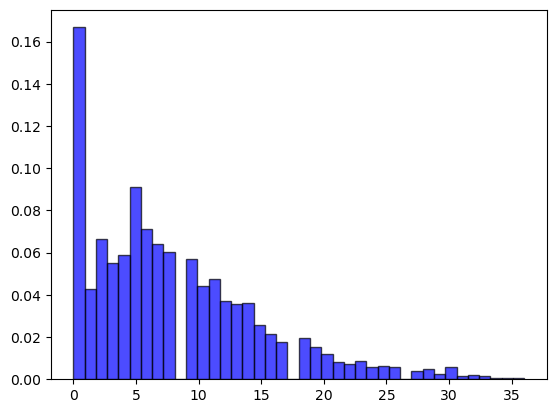

In [800]:
plt.hist(samples['Call Failure'], bins=40, alpha=0.7, density=True, color='blue', edgecolor='black')

plt.show()

### Verifying if Samples Mapped into PCA space have no multicolinearity

In [801]:
x_sample_ori_scaled = scaler_ori.transform(samples)
x_sample_pca = pca.transform(x_sample_ori_scaled)

exog = pd.DataFrame(x_sample_pca, columns=samples.columns)
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 1.3666065703377472,
 'Call Failure': 1.8704713560278436,
 'Complains': 17.554608095042752,
 'Subscription Length': 40.75946103458566,
 'Charge Amount': 120.61178295120015,
 'Seconds of Use': 9.685384594908435,
 'Frequency of Use': 87.13641733824014,
 'Frequency of SMS': 125.7549720734526,
 'Distinct Called Numbers': 1.9651781400930308,
 'Age Group': 2.7194350100456535,
 'Pay On Contract': 3.510393411426643,
 'Inactivity': 47.64645110436364,
 'Customer Value': 21.62742612112231,
 'Call Failure Rate': 7.769975179925251,
 'Average Sec per Call': 1.088554847395684}

### Based on above VIF, there is multicolinearity in the PCA mapped space for the generated samples

### Checking same test for subset columns - without PCA

In [802]:
x_sample_sub_scaled = scaler_sub.transform(samples.drop(columns=['Seconds of Use', 'Frequency of SMS']))

exog = pd.DataFrame(x_sample_sub_scaled, columns=samples.drop(columns=['Seconds of Use', 'Frequency of SMS']).columns)
exog = sm.add_constant(exog)
vif_score = {}
for i in range(0,len(exog.columns.tolist())):
    vif_score[exog.columns.tolist()[i]] = variance_inflation_factor(exog, i)
vif_score

{'const': 1.3618131792851687,
 'Call Failure': 1.4045830685802076,
 'Complains': 1.0012746321078083,
 'Subscription Length': 1.0003038423573338,
 'Charge Amount': 1.000715133458953,
 'Frequency of Use': 1.5380028014531266,
 'Distinct Called Numbers': 1.0008806557386,
 'Age Group': 1.0012265662395219,
 'Pay On Contract': 1.001123074383059,
 'Inactivity': 1.0008717919860872,
 'Customer Value': 1.000664222312444,
 'Call Failure Rate': 2.0444443662601675,
 'Average Sec per Call': 1.261176673440992}

### Is much better than PCA mapped results so using **BTC (subset)** model for prediction 

<a id="prediction"></a>
## Prediction

In [803]:
models_sub

{'log_sub': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'svc_sub': SVC(class_weight='balanced', probability=True, random_state=42),
 'rf_sub': RandomForestClassifier(class_weight='balanced', random_state=42),
 'btc_sub': LGBMClassifier(class_weight='balanced', random_state=42, verbosity=-1)}

In [804]:
y_pred_sample = btc_sub.predict(x_sample_sub_scaled)
unique_values, counts = np.unique(y_pred_sample, return_counts=True)
print(unique_values)
print(counts)

[0 1]
[8734 1266]


<a id="sci_questions"></a>
## Answering Scientific Questions

In [805]:
new_sample_data = samples.copy()
new_sample_data['Predict Churn'] = y_pred_sample

<a id="churn_call_fail"></a>
### 95% CI for Number of Call Failures of Churned Customer

In [806]:
sample_call_failure = new_sample_data.loc[new_sample_data['Predict Churn']==1,:]['Call Failure']
sample_call_failure_no_churn = new_sample_data.loc[new_sample_data['Predict Churn']==0,:]['Call Failure']

1266


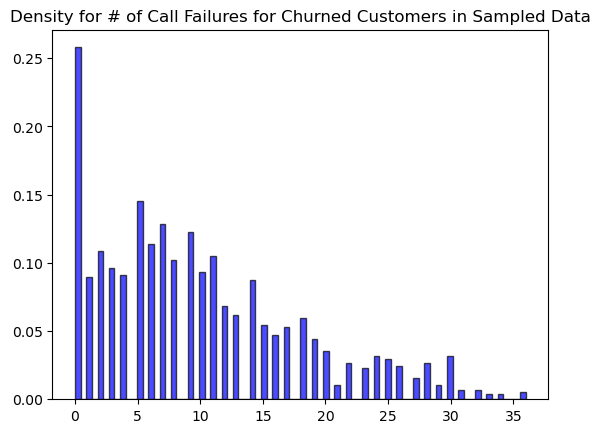

In [807]:
print(new_sample_data.loc[new_sample_data['Predict Churn']==1,:]['Call Failure'].shape[0])
plt.hist(new_sample_data[new_sample_data['Predict Churn']==1]['Call Failure'], bins=80, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Density for # of Call Failures for Churned Customers in Sampled Data')
plt.show()

495


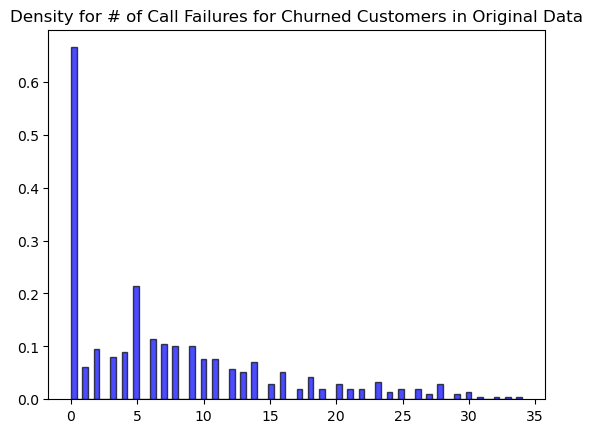

In [808]:
print(data[data['Churn']==1]['Call Failure'].shape[0])
plt.hist(data[data['Churn']==1]['Call Failure'], bins=80, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Density for # of Call Failures for Churned Customers in Original Data')
plt.show()

In [809]:
bootstrap_means = []
for i in range(10000):
    bootstrap_sample = np.random.choice(sample_call_failure.values, size=len(sample_call_failure.values), replace=True)
    sample_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(sample_mean)

lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(f"95% CI for Number of Call Failure for Churned Customer: ({lower_bound}, {upper_bound})")

95% CI for Number of Call Failure for Churned Customer: (9.435209320695103, 10.322274881516588)


In [810]:
m = sample_call_failure.mean()
std = sample_call_failure.std()
sem = std / np.sqrt(len(sample_call_failure))
print(m)
print(sem)
confidence_level = 0.99
ci = stats.t.interval(confidence_level, len(sample_call_failure)-1, loc=m, scale=sem)
print(f"Mean: {m}")
print(f"99% CI: {ci}")

9.883096366508688
0.22759546995753369
Mean: 9.883096366508688
99% CI: (9.29596345542601, 10.470229277591367)


In [811]:
bootstrap_means = []
for i in range(10000):
    bootstrap_sample = np.random.choice(sample_call_failure_no_churn.values, size=len(sample_call_failure_no_churn.values), replace=True)
    sample_mean = np.mean(bootstrap_sample)
    bootstrap_means.append(sample_mean)

lower_bound_no_churn = np.percentile(bootstrap_means, 2.5)
upper_bound_no_churn = np.percentile(bootstrap_means, 97.5)

print(f"95% CI for Number of Call Failure for Non-churn Customer: ({lower_bound_no_churn}, {upper_bound_no_churn})")

95% CI for Number of Call Failure for Non-churn Customer: (7.56846519349668, 7.845775131669338)


<a id="q1_results"></a>
#### Interpreting Results    

**A 95% CI around number of call failures for churned customers is approx. 9 to 11 call failures.** Because the CI for number of call failures for churned vs non-churned customers is different, this means a customer is more likely to churn if the number of call failures they experience is greater than 9.

The CI was calculated using bootstrap resampling (because data is right skewed so classic CI calculations would be inaccurate as they assume symmetric distribution about the mean). However, using classic CI calculations we see similar interval as the bootstrapping result - most likely because the density of 0 in the sampled data is much lower than in the original data.    

Looking at the histogram, we see a similar pattern between the sampled and original, however, looking at the density of 0 Call Failures in the original data is above 0.6 whereas in the sample its slightly more than 0.25. Moreover, the 2nd peak is much lower in the original data compared to the sampled.   
The difference is most likely due to the independent sampling whereas in the original data, there is probably some correlation (if not linear than something non-linear) between Number of Call Failures and Churn or some other feature. A potential solution to this problem is fitting a multivariate distribution and sampling from that instead.  

<a id="complain_call_fail"></a>
### 95% CI for Number of Call Failures for Complaints

In [812]:
sample_call_failure_complain = new_sample_data.loc[new_sample_data['Complains']==1,:]['Call Failure']
sample_call_failure_complain_no_complain = new_sample_data.loc[new_sample_data['Complains']==0,:]['Call Failure']

782


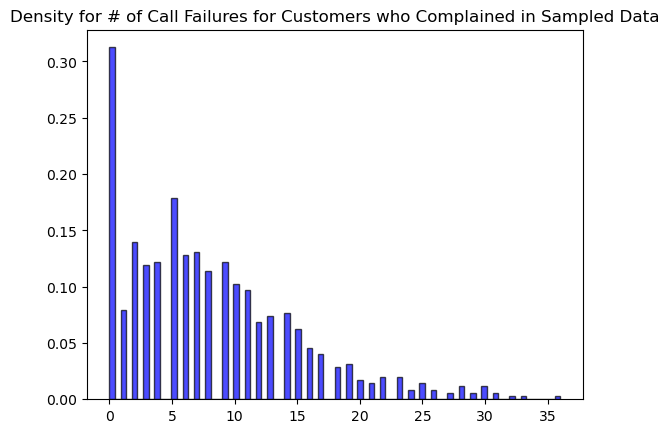

In [813]:
print(new_sample_data.loc[new_sample_data['Complains']==1,:]['Call Failure'].shape[0])
plt.hist(new_sample_data[new_sample_data['Complains']==1]['Call Failure'], bins=80, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Density for # of Call Failures for Customers who Complained in Sampled Data')
plt.show()

241


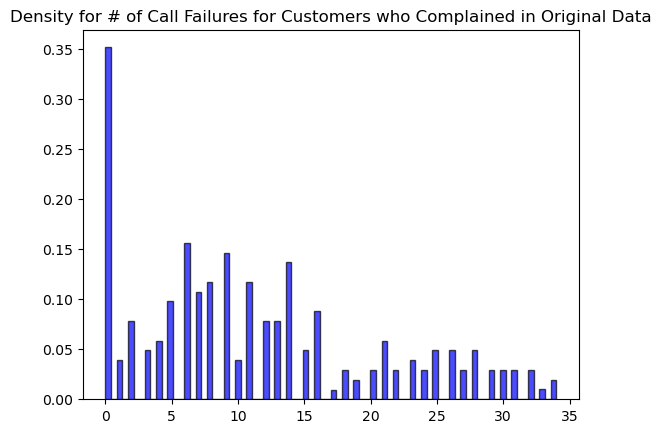

In [814]:
print(data.loc[data['Complains']==1,:]['Call Failure'].shape[0])
plt.hist(data[data['Complains']==1]['Call Failure'], bins=80, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Density for # of Call Failures for Customers who Complained in Original Data')
plt.show()

In [815]:
bootstrap_means_complain = []
for i in range(10000):
    bootstrap_sample = np.random.choice(sample_call_failure_complain.values, size=len(sample_call_failure_complain.values), replace=True)
    sample_mean = np.mean(bootstrap_sample)
    bootstrap_means_complain.append(sample_mean)

lower_bound_complain = np.percentile(bootstrap_means_complain, 2.5)
upper_bound_complain = np.percentile(bootstrap_means_complain, 97.5)

print(f"95% CI for Number of Call Failure for Customer who Complained: ({lower_bound_complain}, {upper_bound_complain})")

95% CI for Number of Call Failure for Customer who Complained: (7.586924552429668, 8.543478260869565)


In [816]:
m_complain = sample_call_failure_complain.mean()
std_complain = sample_call_failure_complain.std()
sem_complain = std_complain / np.sqrt(len(sample_call_failure_complain))
print(m_complain)
print(sem_complain)
confidence_level = 0.99
ci_complain = stats.t.interval(confidence_level, len(sample_call_failure_complain)-1, loc=m_complain, scale=sem_complain)
print(f"Mean: {m_complain}")
print(f"99% CI: {ci_complain}")

8.070332480818415
0.245445166534571
Mean: 8.070332480818415
99% CI: (7.436558941835825, 8.704106019801005)


In [817]:
bootstrap_means_complain = []
for i in range(10000):
    bootstrap_sample = np.random.choice(sample_call_failure_complain_no_complain.values, 
                                        size=len(sample_call_failure_complain_no_complain.values), replace=True)
    sample_mean = np.mean(bootstrap_sample)
    bootstrap_means_complain.append(sample_mean)

lower_bound_complain_no_complain = np.percentile(bootstrap_means_complain, 2.5)
upper_bound_complain_no_complain = np.percentile(bootstrap_means_complain, 97.5)

print(f"95% CI for Number of Call Failure for Customer who Did Not Complain: ({lower_bound_complain_no_complain}, {upper_bound_complain_no_complain})")

95% CI for Number of Call Failure for Customer who Did Not Complain: (7.836187350835322, 8.117490236493817)


<a id="q2_results"></a>
#### Interpreting Results    

**A 95% CI around number of call failures for customers who complained is approx. 7 to 9 call failures.** Because the CI for number of call failures for complained vs no-complaints customers overlaps, this means a customer who complains is likely complaining NOT because of the number of call failures.

The CI was calculated using bootstrap resampling (because data is right skewed so classic CI calculations would be inaccurate as they assume symmetric distribution about the mean). However, using classic CI calculations we see similar interval as the bootstrapping result.

Looking at the histogram, we see a similar pattern between the sampled and original, where the 0 and 2nd peak densities match reasonably well. The discrepancy occurs to higher call failure numbers (greater than 20) where the density in the original data is higher than that observed in the sampled data. 

The difference might be due to the density fit where it drops to 0 much more quickly than in the original data. The error could also be because of the independent sampling and sampling from a multivariate distribution may improve this result. 

<a id="churn_reduced"></a>
### Reduction in Churn for 50% decrease in Number of Call Failures

In [818]:
new_samples = samples.copy()
new_samples['Call Failure'] = new_samples['Call Failure'] / 2
new_samples['Call Failure'] = new_samples['Call Failure'].astype(int)

In [819]:
x_new_sample_sub_scaled = scaler_sub.transform(new_samples.drop(columns=['Seconds of Use', 'Frequency of SMS']))

y_pred_new_sample = btc_sub.predict(x_new_sample_sub_scaled)
unique_values_reduced, counts_reduced = np.unique(y_pred_new_sample, return_counts=True)
print(unique_values_reduced)
print(counts_reduced)

[0 1]
[8815 1185]


In [820]:
reduction =  counts[1] - counts_reduced[1]
reduction_rate = (reduction/counts[1])*100
print(reduction)
print(reduction_rate)

81
6.398104265402843


<a id="q3_results"></a>
#### Interpreting Results    

**A 50% reduction in number of call failures leads to a 6% reduction in churn.**     

The number of call failures in the sampled data were all halved, to represent a 50% reduction in call failures. The BTC (subset) model was again used to predict on this altered sampled data, and the number of churned customers was 1185, compared to 1266 in the orignal prediction of the sampled data, resulting in a 6% decrease.    

Perhaps a larger decrease in churn could be attained if a more significant feature was reduced. From the Lasso graph, Inactivity was a very important feature. In fact, looking at the results below - p_inactive (probability of inactivity) is halved from 25% to 12.5% instead of number of call failures, and approx. a 23% reduction in churn is observed, dropping from 1266 to 972 predicted customers churned.

In [821]:
np.random.seed(123)

kde = {
    'Call Failure': kde_call_failure,
    'Complains': p_no_complain,
    'Subscription Length': kde_sub_length ,
    'Charge Amount': [loc_charge_amount, scale_charge_amount],
    'Seconds of Use': kde_sec_of_use,
    'Frequency of Use': kde_freq_of_use, 
    'Frequency of SMS': kde_freq_of_sms,
    'Distinct Called Numbers': kde_distinct_num_called, 
    'Pay On Contract': p_no_pay_on_contract, 
    'Inactivity': 0.125,
    'Age Group': norm_age_group,
    'Customer Value': kde_cust_value
}

def sample_kde_with_threshold(density, lower_bound, num_samples):
    samples = []
    while len(samples) < num_samples:
        sample = density.sample(1)[0][0]
        if sample >= lower_bound:
            samples.append(sample)
    return np.array(samples)

lower_bound = 0 
num_samples = 10000

samples = pd.DataFrame()
for feature, density in kde.items():
    if isinstance(density, KernelDensity):
        feature_samples = sample_kde_with_threshold(density, lower_bound, num_samples)
    elif feature == 'Age Group':
        feature_samples = np.random.normal(density[0], density[1], num_samples)
    elif feature in ['Complains', 'Pay On Contract', 'Inactivity']:
        feature_samples = np.random.binomial(1, p=density, size=num_samples)
    elif feature == 'Charge Amount':
        feature_samples = np.random.exponential(scale=density[1], size=num_samples) + density[0]
    else:
        feature_samples = np.full(num_samples, density)
    samples[feature] = feature_samples
samples.head()
samples.describe()


samples.loc[samples['Age Group'] <= 1.9, 'Age Group'] = 1
samples.loc[(samples['Age Group'] > 1.9) & (samples['Age Group'] <= 2.9), 'Age Group'] = 2
samples.loc[(samples['Age Group'] > 2.9) & (samples['Age Group'] <= 3.9), 'Age Group'] = 3
samples.loc[(samples['Age Group'] > 3.9) & (samples['Age Group'] <= 4.9), 'Age Group'] = 4
samples.loc[samples['Age Group'] > 4.9, 'Age Group'] = 5
samples['Age Group'] = samples['Age Group'].astype(int)

samples.loc[(samples['Charge Amount'] < 0.8), 'Charge Amount'] = 0
samples['Charge Amount'] = samples['Charge Amount'].round().astype(int)

samples.loc[(samples['Call Failure'] < 0.95), 'Call Failure'] = 0
samples['Call Failure'] = samples['Call Failure'].round().astype(int)

samples['Subscription Length'] = samples['Subscription Length'].round().astype(int)
samples['Seconds of Use'] = samples['Seconds of Use'].round().astype(int)
samples['Frequency of Use'] = samples['Frequency of Use'].round().astype(int)
samples['Frequency of SMS'] = samples['Frequency of SMS'].round().astype(int)
samples['Distinct Called Numbers'] = samples['Distinct Called Numbers'].round().astype(int)

samples.loc[samples['Call Failure'] > samples['Frequency of Use'], 'Call Failure'] = samples['Frequency of Use'] # can't have more failures than calls
samples.loc[samples['Frequency of Use']==0, 'Seconds of Use'] = 0 # if frequency of use is 0 then seconds of use also has to be 0

samples['Call Failure Rate'] = samples['Call Failure'] / samples['Frequency of Use']
mean_cfr = samples['Call Failure Rate'].mean()
samples['Call Failure Rate'] = samples['Call Failure Rate'].fillna(value=mean_cfr)

samples['Average Sec per Call'] = samples['Seconds of Use']/samples['Frequency of Use']
mean_avg_sec_per_call = samples['Average Sec per Call'].mean()
samples.fillna({'Average Sec per Call':mean_avg_sec_per_call}, inplace=True)

samples = samples[['Call Failure', 'Complains', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of Use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Pay On Contract', 'Inactivity',
       'Customer Value', 'Call Failure Rate', 'Average Sec per Call']]
x_sample_sub_scaled = scaler_sub.transform(samples.drop(columns=['Seconds of Use', 'Frequency of SMS']))
y_pred_sample = btc_sub.predict(x_sample_sub_scaled)
unique_values, counts = np.unique(y_pred_sample, return_counts=True)
print(unique_values)
print(counts)
print((1266-counts[1])/1266*100)

[0 1]
[9028  972]
23.22274881516588
